# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
res_index = 0 # for UA Q1
flux_index = 0 # for UA Q1

2023-10-23 16:28:08,835 - qm - INFO     - Starting session: 834f560f-fcca-421a-94f1-e96e616c3e7d


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [ ]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [ ]:
Experiment.octave_calibration(qubit_index,res_index,flux_index)

## Time of flight

In [ ]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10000, cd_time = 10E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [ ]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += 0.002220
machine.global_parameters.con1_downconversion_offset_Q += 0.002710
Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [ ]:
%matplotlib qt
res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, n_avg = 5E3, cd_time = 5E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)

In [ ]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist()
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [ ]:
res_freq_sweep = np.arange(7.254E9,7.267E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 1E3, cd_time = 10E3)

In [ ]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [ ]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [3]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.67s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.72s
resonator frequency: 7263.363 MHz


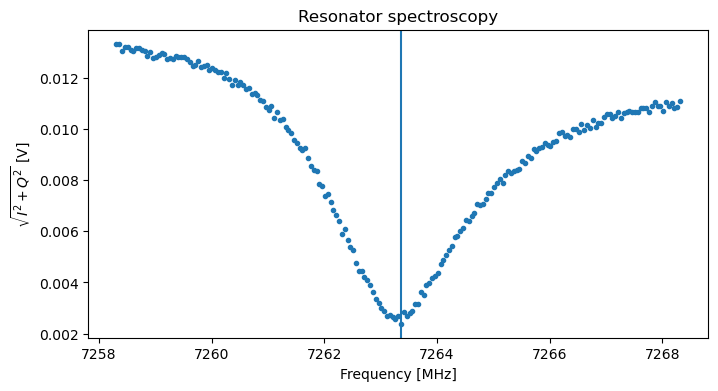

In [4]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, n_avg = 5E3, cd_time = 5E3, plot_flag = False, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

In [5]:
#qubit_freq_sweep = np.arange(6.30E9,6.60E9+1,1E6)
qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-125E6, 125E6 + 1, 2E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, pi_amp_rel = 0.2, ff_amp = 0.0, n_avg = 1E3, cd_time = 10E3, plot_flag = False, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 1.29s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 1.33s


resonant frequency: 6424.589 MHz


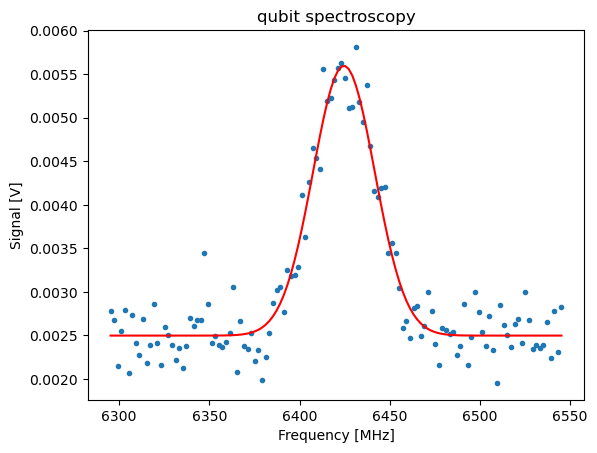

In [6]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2023-10-23 16:28:45,832 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-23 16:28:45,840 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -49.983 MHz)
2023-10-23 16:28:52,678 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.475 GHz, -50.304 MHz)


## Rabi

## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.4,0.4+1E-4,0.05)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 10E3, pi_amp_rel = 0.2, plot_flag = True)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist()
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### test the code